In [112]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_funciones = pd.read_parquet("df_funciones.parquet")

Para el siguiente EDA, se toma el dataset modificado de "movies_dataset" al cual llamamos "df_funciones" donde previamente se realizaron las transformaciones solicitadas 
en la "propuesta de trabajo".
Debido a la limpieza propuesta anteriormente, en este EDA no realizaremos desanidaciones, revision de valores nulos, ajustes en formato de fecha y eliminacion
de columnas no necesarias ya que durante el proceso de ETL fueron ajustadas. Adicionalmente se limito el DF a las columnas: 'title','release_date','release_year','popularity','spoken_languages_name','vote_count','vote_average' y peliculas donde solo se hablaran los idiomas:'English', 'Italiano', 'Español' para optimizar espacio en la memoria. Tambien para que se pudiera transformar el DF a formato parquet se realizaron ajustes a la columna 'popularity' para obtener el tipo de dato numerico.   

In [101]:
#Se usan .head() y .info() para ver la informacion general del dataset, como numero de filas y columnas, tipos de datos y peso de memoria. 
print(df_funciones.head())
print(df_funciones.info())



                          title release_date  release_year  popularity  \
0                      fantasia   1940-11-13          1940    8.037960   
1                      fantasia   1940-11-13          1940    8.037960   
2                      fantasia   1940-11-13          1940    8.037960   
3  why we fight: prelude to war   1942-05-27          1942    0.476623   
4  why we fight: prelude to war   1942-05-27          1942    0.476623   

  spoken_languages_name  vote_count  vote_average belongs_to_collection_name  \
0               english       831.0           7.2        Fantasia Collection   
1               english       831.0           7.2        Fantasia Collection   
2               english       831.0           7.2        Fantasia Collection   
3               english         5.0           5.6               Why We Fight   
4               english         5.0           5.6               Why We Fight   

   genres_name     overview  
0    animation    animation  
1       family

In [102]:
df_funciones.columns

Index(['title', 'release_date', 'release_year', 'popularity',
       'spoken_languages_name', 'vote_count', 'vote_average',
       'belongs_to_collection_name', 'genres_name', 'overview'],
      dtype='object')

In [103]:
#Primeramente convertimos los datos de las siguientes columnas de tipo "objeto" a tipo "str" para asegurar su fiabilidad al momento de pasarlas al modelo de similitud de coseno. 
df_funciones[['overview', 'title', 'belongs_to_collection_name']] = df_funciones[['overview', 'title', 'belongs_to_collection_name']].astype(str)

In [104]:
print(df_funciones['title'])

0                             fantasia
1                             fantasia
2                             fantasia
3         why we fight: prelude to war
4         why we fight: prelude to war
                     ...              
2029     transformers: the last knight
2030     transformers: the last knight
2031    war for the planet of the apes
2032    war for the planet of the apes
2033    war for the planet of the apes
Name: title, Length: 2034, dtype: object


Se crea una nube de palabras con el fin de ayudar al sistema de recomendacion, ya que es una representación gráfica en la que el tamaño de cada palabra refleja su frecuencia en el texto, de forma que ayuda a identificar rápidamente temas y términos recurrentes.

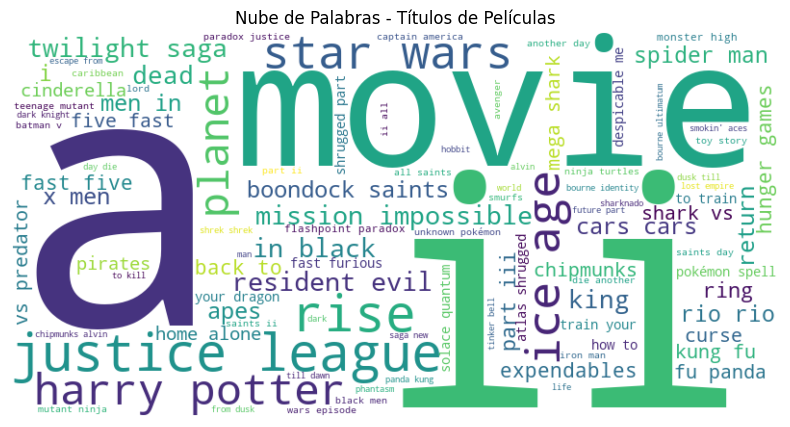

In [105]:

# Combinar todos los títulos en un solo texto
texto_titulos = " ".join(titulo for titulo in df_funciones['title'].astype(str))

# Configurar y generar la nube de palabras
nube_palabras = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    max_words=100, 
    colormap='viridis', 
    stopwords={'and', 'the', 'of'} # Excluir palabras comunes en inglés
).generate(texto_titulos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title("Nube de Palabras - Títulos de Películas")
plt.show()

Se pretende encontrar relaciones en la columna 'belongs_to_collection_name' contando cuántas películas pertenecen a cada colección, con la intencion de dar una idea de qué colecciones son más populares.

C:\Users\pc\AppData\Local\Temp\ipykernel_35164\1113630436.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_colecciones.values, y=top_colecciones.index, palette='viridis')


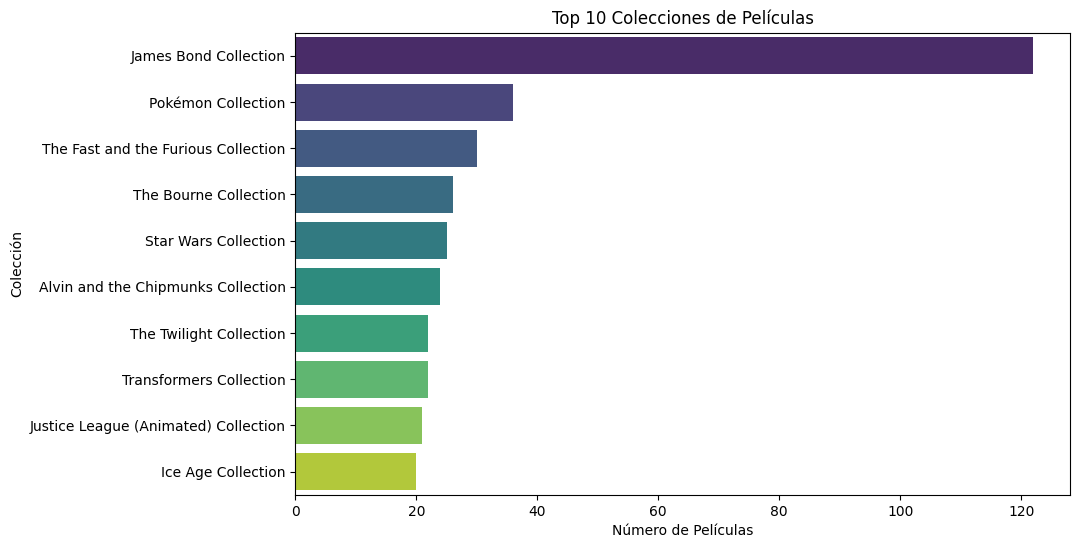

In [106]:
colecciones_counts = df_funciones['belongs_to_collection_name'].value_counts()
top_colecciones = colecciones_counts.head(10) # Selecciona las 10 colecciones más populares para visualizar

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_colecciones.values, y=top_colecciones.index, palette='viridis')
plt.title('Top 10 Colecciones de Películas')
plt.xlabel('Número de Películas')
plt.ylabel('Colección')
plt.show()

Se realiza un analisis de frecuencia de generos para saber cuantas peliculas hay en cada genero, posteriormente se utiliza un grafico de barras para representar la frecuencia de las mismas. 

C:\Users\pc\AppData\Local\Temp\ipykernel_35164\3297254709.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


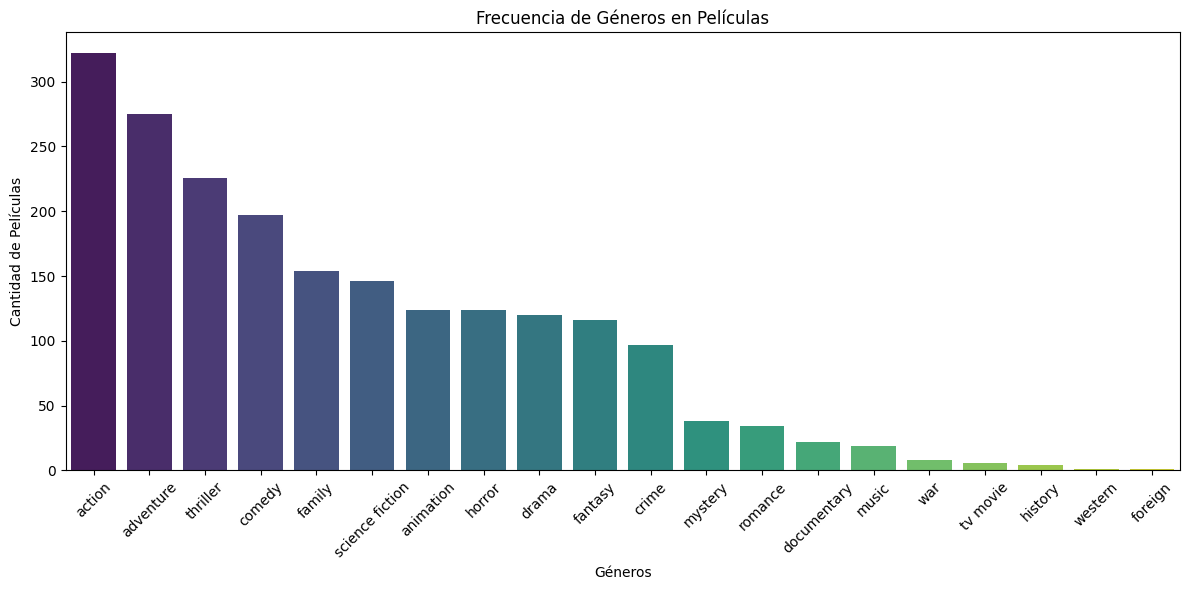

In [107]:
genre_counts = df_funciones['genres_name'].value_counts() #cuenta la freccuencia de cada genero 

# Configura el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Frecuencia de Géneros en Películas')
plt.xlabel('Géneros')
plt.ylabel('Cantidad de Películas')
plt.tight_layout()
plt.show()

Se crea un grafico de dispercion que muestra la relacion entre el número de votos y la popularidad de las películas. Pretende observar si hay alguna correlación entre el número de votos que recibe una película y su popularidad.

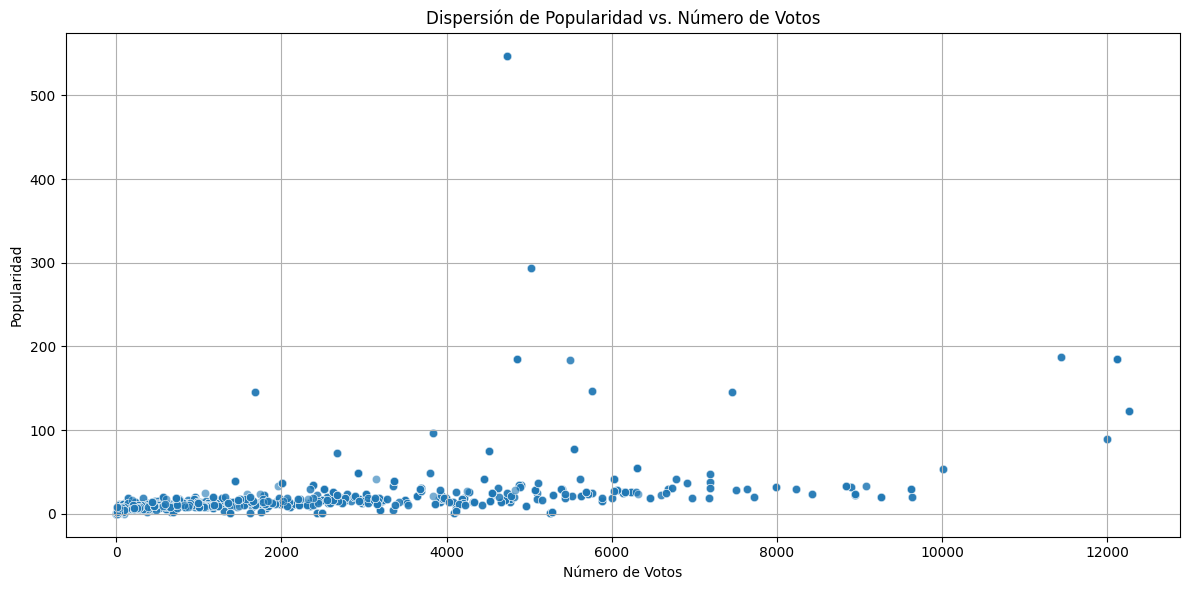

In [108]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='vote_count', y='popularity', data=df_funciones, alpha=0.6)
plt.title('Dispersión de Popularidad vs. Número de Votos')
plt.xlabel('Número de Votos')
plt.ylabel('Popularidad')
plt.grid()
plt.tight_layout()
plt.show()


similitud de coseno 

In [119]:
# Paso 1: Combina columnas relevantes en un solo texto para cada película
df_funciones['combined_features'] = df_funciones['genres_name'] + ' ' + df_funciones['belongs_to_collection_name'] + ' ' + df_funciones['overview']

# Paso 2: Vectorización TF-IDF para convertir el texto en vectores de características
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_funciones['combined_features'].fillna(''))  # Llenamos NaN con cadenas vacías

# Paso 3: Función de recomendación
def recomendacion(titulo):
    # Verificamos si la película ingresada existe en el DataFrame
    if titulo not in df_funciones['title'].values:
        return "La película no se encuentra en el dataset."
    
    # Encontramos el índice de la película ingresada
    idx = df_funciones[df_funciones['title'] == titulo].index[0]
    
    # Calculamos la similitud de coseno entre la película ingresada y todas las demás
    cosine_similarities = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Ordenamos los índices en base a la similitud (de mayor a menor) y seleccionamos las 5 más similares
    similar_indices = cosine_similarities.argsort()[-6:-1][::-1]  # Excluye la película misma (primer lugar)
    
    # Extraemos los títulos de las películas recomendadas
    recommended_titles = df_funciones.iloc[similar_indices]['title'].tolist()
    
    return recommended_titles

# Ejemplo de uso
pelicula_input = "from russia with love"  # Título de la película a buscar
recomendaciones = recomendacion(pelicula_input)
print(f"Películas recomendadas para '{pelicula_input}':", recomendaciones)

Películas recomendadas para 'from russia with love': ['never say never again', 'a view to a kill', 'the living daylights', 'goldeneye', 'live and let die']


In [ ]:
print(df_funciones['title'].head(50))